# Libs and pre-definitions

In [ ]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from torch import nn

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data

# Train classifier

## Definitions

In [ ]:
CREATE_DIR = True #If true, creates directories to save model (weights_path)
LIVE_PLOT = True #If True, plot* loss while training. If 'print', print loss per epoch
SAVE_CHECKPOINT = True #If True, save (and update) model weights for the best epoch (smallest validation loss)
SAVE_ALL = False #If True, saves weights and trainer at the end of training

In [12]:
MODEL_ARC = 'VGG_16'#WideResNet ResNet101,ResNet18,ResNet34,ResNet50 CNN8
DATA = 'Cifar100'
loss_criterion = nn.NLLLoss(); Softmax = 'log'

N_EPOCHS = 200
risk_dict = None#{'selective_risk_mcp':  lambda x,label: unc_comp.selective_risk(x,label,unc_type = unc.MCP_unc)}

In [15]:
data = torch_data.__dict__[DATA](data_dir = DATA_PATH)
num_classes = data.n_classes
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)

if CREATE_DIR and not os.path.isdir(weights_path):
    os.makedirs(weights_path)

Files already downloaded and verified
Files already downloaded and verified


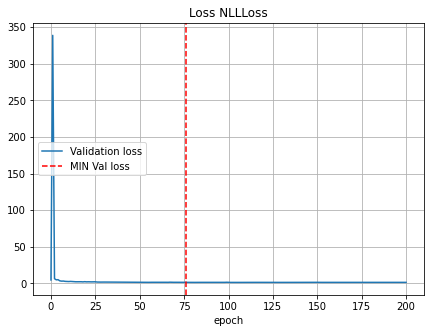

Acc_val (max): 71.57 (71.63) | Progress:: 100%|#########9| 199/200 [57:32<00:17, 17.24s/it]

Conjunto de treinamento: acc =  99.738
Conjunto de teste: acc =  71.36
Conjunto de teste: MAX acc =  71.63


In [17]:
name = MODEL_ARC + '_' + DATA
model = model_class(num_classes = data.n_classes,softmax = Softmax,name = name).to(dev)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum = 0.9,weight_decay = 5e-4,nesterov = True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.5)

model_trainer = TE.Trainer(model,optimizer,loss_criterion, None,data.test_dataloader,lr_scheduler = scheduler, risk_dict = risk_dict)
model_trainer.fit(data.train_dataloader,N_EPOCHS, live_plot = LIVE_PLOT,save_checkpoint = SAVE_CHECKPOINT,PATH = weights_path)

model.eval()
acc = TE.model_acc(model,data.train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(model,data.test_dataloader)
print('Conjunto de teste: acc = ', acc)
print(f'Conjunto de teste: MAX acc (argmax epoch) = {max(model_trainer.hist_val.acc_list)}({np.argmax(model_trainer.hist_val.acc_list)})')

if SAVE_ALL:
    model_trainer.save_all(weights_path, PATH_TRAINER,name)
    